## Importing Libraries

In [1]:
# import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import math
import matplotlib.dates as mdates 
from torchsummaryX import summary

# To auto load the customise module
%load_ext autoreload
%autoreload 2
import deep_learning_module
import data_module

## Hyperparameter

In [2]:
split_ratio = 0.70
num_epochs = 60
window_size = 6
batch_size = 5
n_step = 3
learning_rate = 0.001
# seed
torch.manual_seed(123)

## Data Preparation

In [3]:
df = pd.read_csv("../../datasets/traffic/train_ML_IOT.csv")
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
# compute dtype
for column in df.columns:
    print(f"The data type for '{column}' column is: {df[column].dtype}")

The data type for 'DateTime' column is: object
The data type for 'Junction' column is: int64
The data type for 'Vehicles' column is: int64
The data type for 'ID' column is: int64


In [5]:
# Check if there's any NaN values
df.isnull().values.any()

False

In [6]:
# compute descriptive statistics
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [7]:
# change DateTime format to DateTime and remove index and ID column
traffic = df.set_index(pd.to_datetime(df["DateTime"]))
traffic = traffic.drop(columns = ['DateTime','ID'])
traffic.head()

,Junction,Vehicles
DateTime,,
2015-11-01 00:00:00,1,15
2015-11-01 01:00:00,1,13
2015-11-01 02:00:00,1,10
2015-11-01 03:00:00,1,7
2015-11-01 04:00:00,1,9


In [8]:
# Change the data type to float 
traffic['Vehicles'] = traffic['Vehicles'].astype(float)

In [9]:
# Split datesets based on junction
traffic1 = traffic.loc[traffic["Junction"] == 1]
traffic2 = traffic.loc[traffic["Junction"] == 2]
traffic3 = traffic.loc[traffic["Junction"] == 3]
traffic4 = traffic.loc[traffic["Junction"] == 4]

In [10]:
# Rename Vehicles to Junction number
traffic1 = traffic1.rename(columns = {'Vehicles': 'Junction_1'})
traffic2 = traffic2.rename(columns = {'Vehicles': 'Junction_2'})
traffic3 = traffic3.rename(columns = {'Vehicles': 'Junction_3'})
traffic4 = traffic4.rename(columns = {'Vehicles': 'Junction_4'})

In [11]:
# Drop the Junction Column
traffic1 = traffic1.drop(columns = ['Junction'])
traffic2 = traffic2.drop(columns = ['Junction'])
traffic3 = traffic3.drop(columns = ['Junction'])
traffic4 = traffic4.drop(columns = ['Junction'])

In [12]:
traffic1.head()

,Junction_1
DateTime,
2015-11-01 00:00:00,15.0
2015-11-01 01:00:00,13.0
2015-11-01 02:00:00,10.0
2015-11-01 03:00:00,7.0
2015-11-01 04:00:00,9.0


In [13]:
# Merge the 4 data frames by their DateTime
all_traffic = pd.concat([traffic1, traffic2, traffic3, traffic4], axis=1)
all_traffic.head()

,Junction_1,Junction_2,Junction_3,Junction_4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN


In [14]:
for column in all_traffic.columns:
    print(f"The number of NaN values in '{column}' column is: {all_traffic[column].isnull().sum()}")

The number of NaN values in 'Junction_1' column is: 0
The number of NaN values in 'Junction_2' column is: 0
The number of NaN values in 'Junction_3' column is: 0
The number of NaN values in 'Junction_4' column is: 10248


In [15]:
all_traffic = all_traffic.fillna(0)
all_traffic.head()

,Junction_1,Junction_2,Junction_3,Junction_4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,0.0
2015-11-01 01:00:00,13.0,6.0,7.0,0.0
2015-11-01 02:00:00,10.0,5.0,5.0,0.0
2015-11-01 03:00:00,7.0,6.0,1.0,0.0
2015-11-01 04:00:00,9.0,7.0,2.0,0.0


In [16]:
all_traffic["Junction_1"].head()

DateTime
2015-11-01 00:00:00    15.0
2015-11-01 01:00:00    13.0
2015-11-01 02:00:00    10.0
2015-11-01 03:00:00     7.0
2015-11-01 04:00:00     9.0
Freq: H, Name: Junction_1, dtype: float64

Text(0.5, 1.0, 'Number of Vehicles at 4 different Junctions')

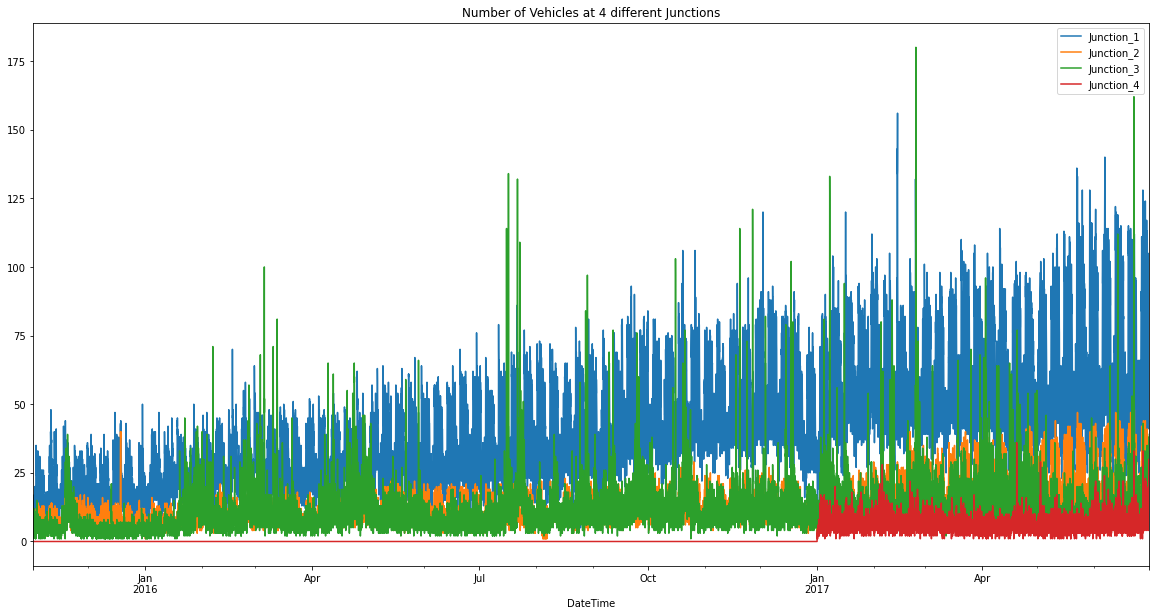

In [17]:
all_traffic.plot(figsize = (20,10))
plt.title("Number of Vehicles at 4 different Junctions")

# Junction 1

## Data Splitting

In [18]:
# Split the data with ratio as state in hyperparameter
split_data = round(len(all_traffic["Junction_1"])*split_ratio)
split_data

10214

In [19]:
# Split data by indexing 
train_data = all_traffic["Junction_1"].values[:split_data]
test_data = all_traffic["Junction_1"].values[split_data:]
train_time = all_traffic["Junction_1"].index[:split_data]
test_time = all_traffic["Junction_1"].index[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(10214,)
test_data_shape
(4378,)


## Data Standardization

In [20]:
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.reshape(-1, 1))

test_data_standard = scaler.transform(test_data.reshape(-1, 1))

## Data Sequencing

In [21]:
trainX, trainY = data_module.univariate_multi_step(train_data_standard, window_size, n_step)
testX, testY = data_module.univariate_multi_step(test_data_standard, window_size, n_step)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(10206, 6, 1) trainY shape:(10206, 3, 1)

testX shape:(4370, 6, 1) testY shape:(4370, 3, 1)


## Data Transform

In [22]:
train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)


train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)

In [23]:
data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([10206, 6, 1])
train_data_y_label shape : torch.Size([10206, 3, 1])
test_data_x_feature shape : torch.Size([4370, 6, 1])
test_data_y_label shape : torch.Size([4370, 3, 1])


## Data Transpose

In [24]:
# Data Transpose to suit for CNN 
train_data_dict , test_data_dict= data_module.transpose(train_data_dict,test_data_dict)

In [25]:
data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([10206, 1, 6])
train_data_y_label shape : torch.Size([10206, 3, 1])
test_data_x_feature shape : torch.Size([4370, 1, 6])
test_data_y_label shape : torch.Size([4370, 3, 1])


## Data Iterator

In [26]:
train_iter , test_iter = data_module.iterator(train_data_dict ,test_data_dict,batch_size = batch_size)

## Input Model

In [27]:
# seed
torch.manual_seed(123)
n_feature = train_data_dict['train_data_x_feature'].shape[1]

# Input the attribute need by the model 
model = deep_learning_module.CNN(n_feature = n_feature,n_step = n_step )

# Define the optimizer (Here we use SGD as our optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function (Here we use MSE as the loss function)
loss_fn = nn.MSELoss()

In [28]:
seq_length = train_data_dict['train_data_x_feature'].shape[2]
inputs = torch.zeros((batch_size,n_feature ,seq_length),dtype=torch.float) # batch size ,input_dim ,seq_length
print(summary(model,inputs))

        Kernel Shape Output Shape Params Mult-Adds
Layer                                             
0_conv1   [1, 30, 3]   [5, 30, 4]  120.0     360.0
1_poo1             -   [5, 30, 2]      -         -
2_conv2  [30, 20, 2]   [5, 20, 1]  1.22k      1.2k
3_pool2            -   [5, 20, 1]      -         -
4_fc1       [20, 10]      [5, 10]  210.0     200.0
5_fc2        [10, 3]       [5, 3]   33.0      30.0
----------------------------------------------------
                      Totals
Total params          1.583k
Trainable params      1.583k
Non-trainable params     0.0
Mult-Adds              1.79k
        Kernel Shape Output Shape  Params  Mult-Adds
Layer                                               
0_conv1   [1, 30, 3]   [5, 30, 4]   120.0      360.0
1_poo1             -   [5, 30, 2]     NaN        NaN
2_conv2  [30, 20, 2]   [5, 20, 1]  1220.0     1200.0
3_pool2            -   [5, 20, 1]     NaN        NaN
4_fc1       [20, 10]      [5, 10]   210.0      200.0
5_fc2        [10, 3]   

In [29]:
# seed
torch.manual_seed(123)

#  Xavier Weight Initialize 
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

CNN(
  (conv1): Conv1d(1, 30, kernel_size=(3,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
  (pool2): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

## Training

In [30]:
# seed
torch.manual_seed(123)
# Start Training
train_loss, val_loss = deep_learning_module.training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

## Validation

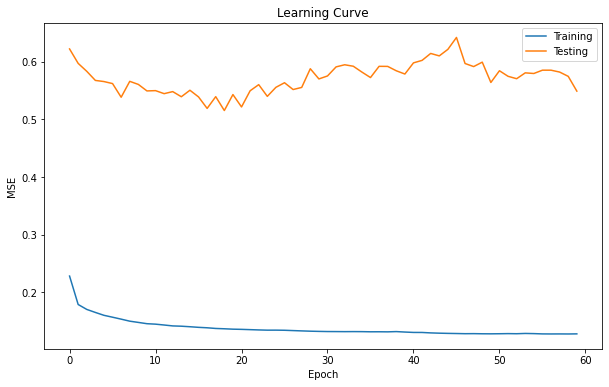

Epoch : 0 , training loss : 0.22816727337598627 , validation loss : 0.622186736103565
Epoch : 1 , training loss : 0.17886192722526606 , validation loss : 0.5971587876335333
Epoch : 2 , training loss : 0.17032982152530804 , validation loss : 0.5833856927782928
Epoch : 3 , training loss : 0.16508591346549556 , validation loss : 0.5675934377143446
Epoch : 4 , training loss : 0.1600869845058904 , validation loss : 0.5656209137755311
Epoch : 5 , training loss : 0.15681655275486314 , validation loss : 0.5621050242664936
Epoch : 6 , training loss : 0.15345389819381874 , validation loss : 0.5384082519065683
Epoch : 7 , training loss : 0.14993480565485404 , validation loss : 0.5659812772923599
Epoch : 8 , training loss : 0.14777399658998566 , validation loss : 0.5606555311164864
Epoch : 9 , training loss : 0.14555772421454494 , validation loss : 0.5493687586171565
Epoch : 10 , training loss : 0.14475123697355086 , validation loss : 0.5498641049489379
Epoch : 11 , training loss : 0.1432734294760

In [31]:
data_module.learning_curve(num_epochs = num_epochs , train_loss = train_loss , val_loss = val_loss )

## Evaluation

In [32]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(train_data_dict['train_data_x_feature'])
    y_test_prediction = model(test_data_dict['test_data_x_feature'])

In [33]:
# Assign evaluation key

prediction , output = data_module.key_assign_evaluation(y_train_prediction,
                                                        y_test_prediction,# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(train_data_dict['train_data_x_feature'])
    y_test_prediction = model(test_data_dict['test_data_x_feature'])
                                                        train_data_dict,
                                                        test_data_dict)
# Section 2 : Reshape to original data
# Squeeze the output dimension
output_data = data_module.squeeze_dimension(output)


In [34]:
data_module.sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([10206, 3])
test_data_output shape : torch.Size([4370, 3])


In [35]:
# Section 3 : Invert the scaling back to the original data value
prediction = data_module.inverse_scaler(prediction,scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler)

In [36]:
data_module.sanity_check(data_1 = prediction,data_2 = output_data )

train_data_prediction shape : (10206, 3)
test_data_prediction shape : (4370, 3)
train_data_output shape : (10206, 3)
test_data_output shape : (4370, 3)


In [37]:
# List the forecast value
# data_module.list_forecast_value(output_data,prediction) 

In [38]:
# Section 4 : Calculate the RMSE of train and test data
### BEGIN SOLUTION
trainScore,testScore = data_module.rmse(prediction,output_data)
### END SOLUTION
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 7.53 RMSE
Test Score: 12.71 RMSE


## Forecast Plot

In [39]:
plot_details ={"x-axis" : "Day",
          "y-axis" : "Values",
          "title"  : "Synthetic Data"
         }

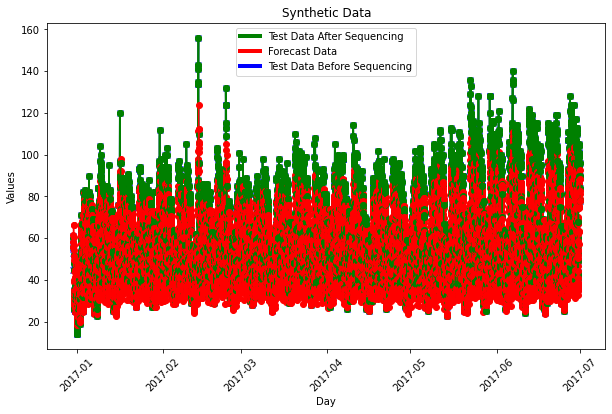

In [40]:
# Use the multi_step_plot function
data_module.multi_step_plot(original_test_data = test_data,
                after_sequence_test_data = output_data ,
                forecast_data = prediction,
                test_time = test_time,
                window_size = window_size ,
                n_step = n_step,
                details = plot_details,
                original_plot = True)

# Junction 2

In [41]:
# Split data by indexing 
train_data = all_traffic["Junction_2"].values[:split_data]
test_data = all_traffic["Junction_2"].values[split_data:]
train_time = all_traffic["Junction_2"].index[:split_data]
test_time = all_traffic["Junction_2"].index[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(10214,)
test_data_shape
(4378,)


In [42]:
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.reshape(-1, 1))

test_data_standard = scaler.transform(test_data.reshape(-1, 1))

In [43]:
trainX, trainY = data_module.univariate_multi_step(train_data_standard, window_size, n_step)
testX, testY = data_module.univariate_multi_step(test_data_standard, window_size, n_step)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(10206, 6, 1) trainY shape:(10206, 3, 1)

testX shape:(4370, 6, 1) testY shape:(4370, 3, 1)


In [44]:
train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)


train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)

data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([10206, 6, 1])
train_data_y_label shape : torch.Size([10206, 3, 1])
test_data_x_feature shape : torch.Size([4370, 6, 1])
test_data_y_label shape : torch.Size([4370, 3, 1])


In [45]:
# Data Transpose to suit for CNN 
train_data_dict , test_data_dict= data_module.transpose(train_data_dict,test_data_dict)

data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([10206, 1, 6])
train_data_y_label shape : torch.Size([10206, 3, 1])
test_data_x_feature shape : torch.Size([4370, 1, 6])
test_data_y_label shape : torch.Size([4370, 3, 1])


In [46]:
train_iter , test_iter = data_module.iterator(train_data_dict ,test_data_dict,batch_size = batch_size)

In [47]:
# seed
torch.manual_seed(123)
n_feature = train_data_dict['train_data_x_feature'].shape[1]

# Input the attribute need by the model 
model = deep_learning_module.CNN(n_feature = n_feature,n_step = n_step )

# Define the optimizer (Here we use SGD as our optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function (Here we use MSE as the loss function)
loss_fn = nn.MSELoss()

In [48]:
seq_length = train_data_dict['train_data_x_feature'].shape[2]
inputs = torch.zeros((batch_size,n_feature ,seq_length),dtype=torch.float) # batch size ,input_dim ,seq_length
print(summary(model,inputs))

        Kernel Shape Output Shape Params Mult-Adds
Layer                                             
0_conv1   [1, 30, 3]   [5, 30, 4]  120.0     360.0
1_poo1             -   [5, 30, 2]      -         -
2_conv2  [30, 20, 2]   [5, 20, 1]  1.22k      1.2k
3_pool2            -   [5, 20, 1]      -         -
4_fc1       [20, 10]      [5, 10]  210.0     200.0
5_fc2        [10, 3]       [5, 3]   33.0      30.0
----------------------------------------------------
                      Totals
Total params          1.583k
Trainable params      1.583k
Non-trainable params     0.0
Mult-Adds              1.79k
        Kernel Shape Output Shape  Params  Mult-Adds
Layer                                               
0_conv1   [1, 30, 3]   [5, 30, 4]   120.0      360.0
1_poo1             -   [5, 30, 2]     NaN        NaN
2_conv2  [30, 20, 2]   [5, 20, 1]  1220.0     1200.0
3_pool2            -   [5, 20, 1]     NaN        NaN
4_fc1       [20, 10]      [5, 10]   210.0      200.0
5_fc2        [10, 3]   

In [49]:
# seed
torch.manual_seed(123)

#  Xavier Weight Initialize 
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

CNN(
  (conv1): Conv1d(1, 30, kernel_size=(3,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
  (pool2): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

In [50]:
# seed
torch.manual_seed(123)
# Start Training
train_loss, val_loss = deep_learning_module.training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

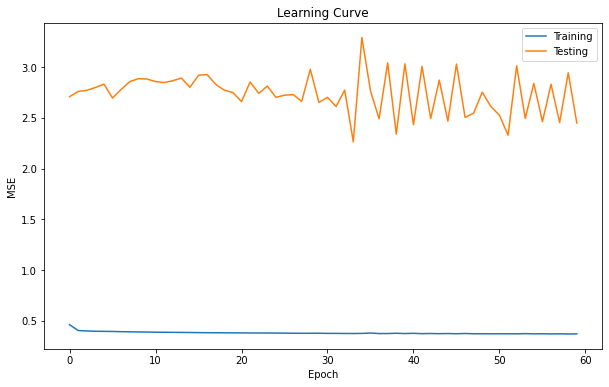

Epoch : 0 , training loss : 0.46074578382130316 , validation loss : 2.7091794632059827
Epoch : 1 , training loss : 0.40321296524196604 , validation loss : 2.760940915297555
Epoch : 2 , training loss : 0.3989249715974287 , validation loss : 2.771799831146063
Epoch : 3 , training loss : 0.39597990943636147 , validation loss : 2.7997254417949193
Epoch : 4 , training loss : 0.3949582895575018 , validation loss : 2.8334045880335625
Epoch : 5 , training loss : 0.3938307387667814 , validation loss : 2.696308999925477
Epoch : 6 , training loss : 0.3918935259781864 , validation loss : 2.7811356979108988
Epoch : 7 , training loss : 0.3905553704311269 , validation loss : 2.8574035431618547
Epoch : 8 , training loss : 0.389150160433976 , validation loss : 2.8873491690534614
Epoch : 9 , training loss : 0.38820133916376653 , validation loss : 2.883526462554352
Epoch : 10 , training loss : 0.38669657194284296 , validation loss : 2.858979861130533
Epoch : 11 , training loss : 0.38597831138879257 , val

In [51]:
data_module.learning_curve(num_epochs = num_epochs , train_loss = train_loss , val_loss = val_loss )

In [52]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(train_data_dict['train_data_x_feature'])
    y_test_prediction = model(test_data_dict['test_data_x_feature'])
    
# Assign evaluation key

prediction , output = data_module.key_assign_evaluation(y_train_prediction,
                                                        y_test_prediction,
                                                        train_data_dict,
                                                        test_data_dict)
# Section 2 : Reshape to original data
# Squeeze the output dimension
output_data = data_module.squeeze_dimension(output)

data_module.sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([10206, 3])
test_data_output shape : torch.Size([4370, 3])


In [53]:
# Section 3 : Invert the scaling back to the original data value
prediction = data_module.inverse_scaler(prediction,scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler)

data_module.sanity_check(data_1 = prediction,data_2 = output_data )

# List the forecast value
# data_module.list_forecast_value(output_data,prediction) 

train_data_prediction shape : (10206, 3)
test_data_prediction shape : (4370, 3)
train_data_output shape : (10206, 3)
test_data_output shape : (4370, 3)


In [54]:
# Section 4 : Calculate the RMSE of train and test data
### BEGIN SOLUTION
trainScore,testScore = data_module.rmse(prediction,output_data)
### END SOLUTION
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.76 RMSE
Test Score: 6.79 RMSE


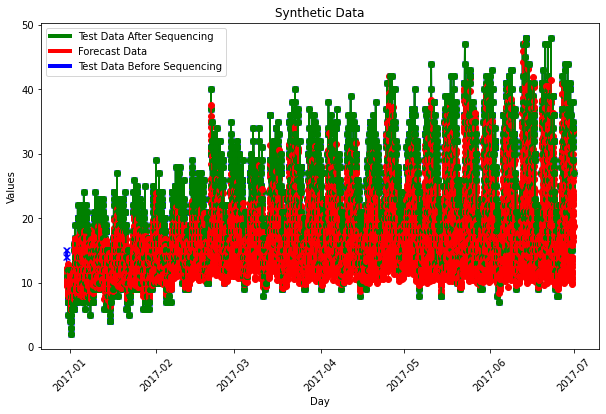

In [55]:
plot_details ={"x-axis" : "Day",
          "y-axis" : "Values",
          "title"  : "Synthetic Data"
         }

# Use the multi_step_plot function
data_module.multi_step_plot(original_test_data = test_data,
                after_sequence_test_data = output_data ,
                forecast_data = prediction,
                test_time = test_time,
                window_size = window_size ,
                n_step = n_step,
                details = plot_details,
                original_plot = True)

## Junction 3

In [56]:
# Split data by indexing 
train_data = all_traffic["Junction_3"].values[:split_data]
test_data = all_traffic["Junction_3"].values[split_data:]
train_time = all_traffic["Junction_3"].index[:split_data]
test_time = all_traffic["Junction_3"].index[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(10214,)
test_data_shape
(4378,)


In [57]:
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.reshape(-1, 1))

test_data_standard = scaler.transform(test_data.reshape(-1, 1))

In [58]:
trainX, trainY = data_module.univariate_multi_step(train_data_standard, window_size, n_step)
testX, testY = data_module.univariate_multi_step(test_data_standard, window_size, n_step)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(10206, 6, 1) trainY shape:(10206, 3, 1)

testX shape:(4370, 6, 1) testY shape:(4370, 3, 1)


In [59]:
train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)


train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)

data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([10206, 6, 1])
train_data_y_label shape : torch.Size([10206, 3, 1])
test_data_x_feature shape : torch.Size([4370, 6, 1])
test_data_y_label shape : torch.Size([4370, 3, 1])


In [60]:
# Data Transpose to suit for CNN 
train_data_dict , test_data_dict= data_module.transpose(train_data_dict,test_data_dict)

data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([10206, 1, 6])
train_data_y_label shape : torch.Size([10206, 3, 1])
test_data_x_feature shape : torch.Size([4370, 1, 6])
test_data_y_label shape : torch.Size([4370, 3, 1])


In [61]:
train_iter , test_iter = data_module.iterator(train_data_dict ,test_data_dict,batch_size = batch_size)

In [62]:
# seed
torch.manual_seed(123)
n_feature = train_data_dict['train_data_x_feature'].shape[1]

# Input the attribute need by the model 
model = deep_learning_module.CNN(n_feature = n_feature,n_step = n_step )

# Define the optimizer (Here we use SGD as our optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function (Here we use MSE as the loss function)
loss_fn = nn.MSELoss()

In [63]:
seq_length = train_data_dict['train_data_x_feature'].shape[2]
inputs = torch.zeros((batch_size,n_feature ,seq_length),dtype=torch.float) # batch size ,input_dim ,seq_length
print(summary(model,inputs))

        Kernel Shape Output Shape Params Mult-Adds
Layer                                             
0_conv1   [1, 30, 3]   [5, 30, 4]  120.0     360.0
1_poo1             -   [5, 30, 2]      -         -
2_conv2  [30, 20, 2]   [5, 20, 1]  1.22k      1.2k
3_pool2            -   [5, 20, 1]      -         -
4_fc1       [20, 10]      [5, 10]  210.0     200.0
5_fc2        [10, 3]       [5, 3]   33.0      30.0
----------------------------------------------------
                      Totals
Total params          1.583k
Trainable params      1.583k
Non-trainable params     0.0
Mult-Adds              1.79k
        Kernel Shape Output Shape  Params  Mult-Adds
Layer                                               
0_conv1   [1, 30, 3]   [5, 30, 4]   120.0      360.0
1_poo1             -   [5, 30, 2]     NaN        NaN
2_conv2  [30, 20, 2]   [5, 20, 1]  1220.0     1200.0
3_pool2            -   [5, 20, 1]     NaN        NaN
4_fc1       [20, 10]      [5, 10]   210.0      200.0
5_fc2        [10, 3]   

In [64]:
# seed
torch.manual_seed(123)

#  Xavier Weight Initialize 
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

CNN(
  (conv1): Conv1d(1, 30, kernel_size=(3,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
  (pool2): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

In [65]:
# seed
torch.manual_seed(123)
# Start Training
train_loss, val_loss = deep_learning_module.training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

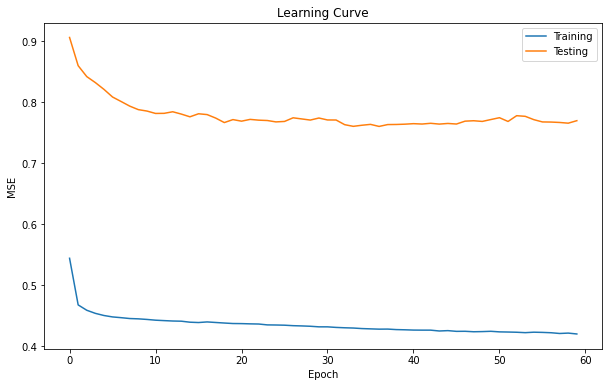

Epoch : 0 , training loss : 0.5442887081713035 , validation loss : 0.9065687742842963
Epoch : 1 , training loss : 0.46778351353669756 , validation loss : 0.8602805748604263
Epoch : 2 , training loss : 0.45900150144921864 , validation loss : 0.8423547233360046
Epoch : 3 , training loss : 0.4539110846778255 , validation loss : 0.8325215889805889
Epoch : 4 , training loss : 0.450385781844365 , validation loss : 0.821413288149744
Epoch : 5 , training loss : 0.4480572263917572 , validation loss : 0.808861110744107
Epoch : 6 , training loss : 0.4468237063878508 , validation loss : 0.8014583636599527
Epoch : 7 , training loss : 0.4454222552944568 , validation loss : 0.7939165733515944
Epoch : 8 , training loss : 0.4449085254626996 , validation loss : 0.7881448304097358
Epoch : 9 , training loss : 0.4439362486901821 , validation loss : 0.7858378139156124
Epoch : 10 , training loss : 0.44271135994007066 , validation loss : 0.7819116127771033
Epoch : 11 , training loss : 0.4420010560154891 , val

In [66]:
data_module.learning_curve(num_epochs = num_epochs , train_loss = train_loss , val_loss = val_loss )

In [67]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(train_data_dict['train_data_x_feature'])
    y_test_prediction = model(test_data_dict['test_data_x_feature'])
    
# Assign evaluation key

prediction , output = data_module.key_assign_evaluation(y_train_prediction,
                                                        y_test_prediction,
                                                        train_data_dict,
                                                        test_data_dict)
# Section 2 : Reshape to original data
# Squeeze the output dimension
output_data = data_module.squeeze_dimension(output)

data_module.sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([10206, 3])
test_data_output shape : torch.Size([4370, 3])


In [68]:
# Section 3 : Invert the scaling back to the original data value
prediction = data_module.inverse_scaler(prediction,scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler)

data_module.sanity_check(data_1 = prediction,data_2 = output_data )

# List the forecast value
# data_module.list_forecast_value(output_data,prediction) 

train_data_prediction shape : (10206, 3)
test_data_prediction shape : (4370, 3)
train_data_output shape : (10206, 3)
test_data_output shape : (4370, 3)


In [69]:
# Section 4 : Calculate the RMSE of train and test data
### BEGIN SOLUTION
trainScore,testScore = data_module.rmse(prediction,output_data)
### END SOLUTION
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.44 RMSE
Test Score: 8.37 RMSE


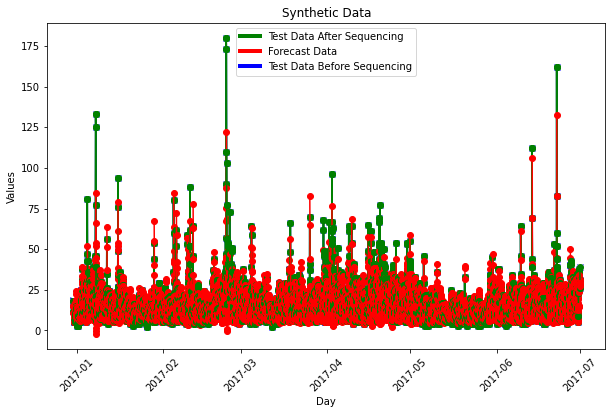

In [70]:
plot_details ={"x-axis" : "Day",
          "y-axis" : "Values",
          "title"  : "Synthetic Data"
         }

# Use the multi_step_plot function
data_module.multi_step_plot(original_test_data = test_data,
                after_sequence_test_data = output_data ,
                forecast_data = prediction,
                test_time = test_time,
                window_size = window_size ,
                n_step = n_step,
                details = plot_details,
                original_plot = True)

## Junction 4

In [71]:
# Split data by indexing 
train_data = all_traffic["Junction_4"].values[:split_data]
test_data = all_traffic["Junction_4"].values[split_data:]
train_time = all_traffic["Junction_4"].index[:split_data]
test_time = all_traffic["Junction_4"].index[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(10214,)
test_data_shape
(4378,)


In [72]:
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.reshape(-1, 1))

test_data_standard = scaler.transform(test_data.reshape(-1, 1))

In [73]:
trainX, trainY = data_module.univariate_multi_step(train_data_standard, window_size, n_step)
testX, testY = data_module.univariate_multi_step(test_data_standard, window_size, n_step)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(10206, 6, 1) trainY shape:(10206, 3, 1)

testX shape:(4370, 6, 1) testY shape:(4370, 3, 1)


In [74]:
train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)


train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)

data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([10206, 6, 1])
train_data_y_label shape : torch.Size([10206, 3, 1])
test_data_x_feature shape : torch.Size([4370, 6, 1])
test_data_y_label shape : torch.Size([4370, 3, 1])


In [75]:
# Data Transpose to suit for CNN 
train_data_dict , test_data_dict= data_module.transpose(train_data_dict,test_data_dict)

data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([10206, 1, 6])
train_data_y_label shape : torch.Size([10206, 3, 1])
test_data_x_feature shape : torch.Size([4370, 1, 6])
test_data_y_label shape : torch.Size([4370, 3, 1])


In [76]:
train_iter , test_iter = data_module.iterator(train_data_dict ,test_data_dict,batch_size = batch_size)

In [77]:
# seed
torch.manual_seed(123)
n_feature = train_data_dict['train_data_x_feature'].shape[1]

# Input the attribute need by the model 
model = deep_learning_module.CNN(n_feature = n_feature,n_step = n_step )

# Define the optimizer (Here we use SGD as our optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function (Here we use MSE as the loss function)
loss_fn = nn.MSELoss()

In [78]:
seq_length = train_data_dict['train_data_x_feature'].shape[2]
inputs = torch.zeros((batch_size,n_feature ,seq_length),dtype=torch.float) # batch size ,input_dim ,seq_length
print(summary(model,inputs))

        Kernel Shape Output Shape Params Mult-Adds
Layer                                             
0_conv1   [1, 30, 3]   [5, 30, 4]  120.0     360.0
1_poo1             -   [5, 30, 2]      -         -
2_conv2  [30, 20, 2]   [5, 20, 1]  1.22k      1.2k
3_pool2            -   [5, 20, 1]      -         -
4_fc1       [20, 10]      [5, 10]  210.0     200.0
5_fc2        [10, 3]       [5, 3]   33.0      30.0
----------------------------------------------------
                      Totals
Total params          1.583k
Trainable params      1.583k
Non-trainable params     0.0
Mult-Adds              1.79k
        Kernel Shape Output Shape  Params  Mult-Adds
Layer                                               
0_conv1   [1, 30, 3]   [5, 30, 4]   120.0      360.0
1_poo1             -   [5, 30, 2]     NaN        NaN
2_conv2  [30, 20, 2]   [5, 20, 1]  1220.0     1200.0
3_pool2            -   [5, 20, 1]     NaN        NaN
4_fc1       [20, 10]      [5, 10]   210.0      200.0
5_fc2        [10, 3]   

In [79]:
# seed
torch.manual_seed(123)

#  Xavier Weight Initialize 
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

CNN(
  (conv1): Conv1d(1, 30, kernel_size=(3,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
  (pool2): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

In [80]:
# seed
torch.manual_seed(123)
# Start Training
train_loss, val_loss = deep_learning_module.training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

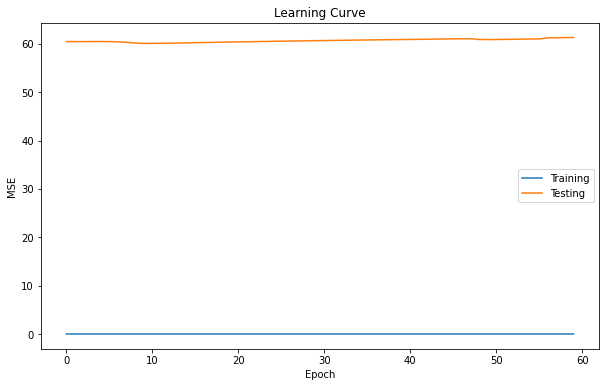

Epoch : 0 , training loss : 0.00030711287785413006 , validation loss : 60.4753612500852
Epoch : 1 , training loss : 2.0523992304037834e-19 , validation loss : 60.47536130464322
Epoch : 2 , training loss : 1.12574951971093e-10 , validation loss : 60.4755124134658
Epoch : 3 , training loss : 1.595062114888976e-09 , validation loss : 60.476831320494206
Epoch : 4 , training loss : 9.154700857759538e-09 , validation loss : 60.48588088900996
Epoch : 5 , training loss : 2.2944005556289327e-08 , validation loss : 60.468719399493885
Epoch : 6 , training loss : 2.363845311399102e-08 , validation loss : 60.42564974661439
Epoch : 7 , training loss : 2.198511046789599e-08 , validation loss : 60.31979377487937
Epoch : 8 , training loss : 2.2569940188873114e-08 , validation loss : 60.18280826343961
Epoch : 9 , training loss : 2.1639118573940258e-08 , validation loss : 60.09121152909195
Epoch : 10 , training loss : 2.0080571458264106e-08 , validation loss : 60.108524261404774
Epoch : 11 , training los

In [81]:
data_module.learning_curve(num_epochs = num_epochs , train_loss = train_loss , val_loss = val_loss )

In [82]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(train_data_dict['train_data_x_feature'])
    y_test_prediction = model(test_data_dict['test_data_x_feature'])
    
# Assign evaluation key

prediction , output = data_module.key_assign_evaluation(y_train_prediction,
                                                        y_test_prediction,
                                                        train_data_dict,
                                                        test_data_dict)
# Section 2 : Reshape to original data
# Squeeze the output dimension
output_data = data_module.squeeze_dimension(output)

data_module.sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([10206, 3])
test_data_output shape : torch.Size([4370, 3])


In [83]:
# Section 3 : Invert the scaling back to the original data value
prediction = data_module.inverse_scaler(prediction,scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler)

data_module.sanity_check(data_1 = prediction,data_2 = output_data )

# List the forecast value
# data_module.list_forecast_value(output_data,prediction) 

train_data_prediction shape : (10206, 3)
test_data_prediction shape : (4370, 3)
train_data_output shape : (10206, 3)
test_data_output shape : (4370, 3)


In [84]:
# Section 4 : Calculate the RMSE of train and test data
### BEGIN SOLUTION
trainScore,testScore = data_module.rmse(prediction,output_data)
### END SOLUTION
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.00 RMSE
Test Score: 7.83 RMSE


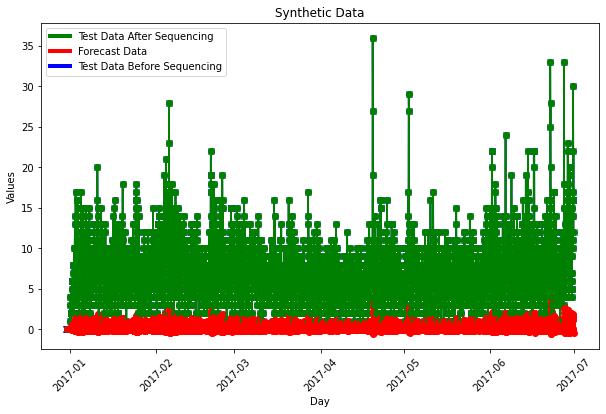

In [85]:
plot_details ={"x-axis" : "Day",
          "y-axis" : "Values",
          "title"  : "Synthetic Data"
         }

# Use the multi_step_plot function
data_module.multi_step_plot(original_test_data = test_data,
                after_sequence_test_data = output_data ,
                forecast_data = prediction,
                test_time = test_time,
                window_size = window_size ,
                n_step = n_step,
                details = plot_details,
                original_plot = True)